# Imports

In [1]:
from common import *

from utils import prepare_data_for_training, save_data, load_set_data, count_labels_set, log_experiment, evaluate_model, show_images, count_labels, plot_sample_images_and_histogram, show_images_and_histograms

from custom_dataset import CustomDataset

from resnet_radimagenet import get_resnet_model

from training_loop import train_model

device = torch.device('mps')

**Plant a seed**

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

**Split the data, preprocess the images, and load them**

In [3]:
train_data, val_data, test_data = prepare_data_for_training()

**Save the generated data into files for better access**

In [ ]:
save_data(train_data, val_data, test_data)

**Load the data from the files in case that is necessary**

In [3]:
train_data, val_data, test_data = load_set_data()

**Print the total length of a certain set and the counts for each class (i.e., Benign and Malignant)**

In [ ]:
data_length, label_counts = count_labels_set(train_data)

print(f"Total items: {data_length}")
print(f"Label counts: {label_counts}")

**Login to Weights and Biases to log all the training info**

In [ ]:
import wandb

wandb.login()

# Ensemble Model Architecture

**Create the custom datasets and loaders**

In [4]:
train_batchsize = 32
eval_batchsize = 10

# Enhanced transform with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),                      # Randomly flip images horizontally
    transforms.RandomRotation(15),                          # Randomly rotate images by up to 15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),    # Randomly crop and resize images to 224x224 pixels
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Randomly adjust brightness and contrast
    transforms.Resize((224, 224))                           # Resize images to 224x224 pixels
])

# Transform for validation and test (only resize)
transform = transforms.Compose([
    transforms.Resize((224, 224))  # Resize images to 224x224 pixels
])

# Flags
downsample = False
data_augmentation = True
oversample = False


# Create datasets with specified transformations and options
train_dataset = CustomDataset(train_data, transform=transform_train, downsample=downsample, oversample=oversample)
val_dataset = CustomDataset(val_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# Create data loaders with specified batch sizes and shuffling options
train_loader = DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=eval_batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=eval_batchsize, shuffle=False)

**Function to plot images from DataLoader and count its labels**

In [ ]:
num_images = 10

show_images(train_loader, num_images)
count_labels(train_loader)

**Calculate class weights**

In [ ]:
train_labels = np.array([1 if label == 'Malignant' else 0 for _, label in train_data])

# Calculate class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(classes))}
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

**Training ResNet (pretrained on RadImageNet)**

In [ ]:
# Load the pre-trained ResNet50 model with the specified number of output classes, 
# optionally freezing the backbone layers during training
net = get_resnet_model("ResNet50.pt", num_classes=2, freeze_backbone=False)

net = net.to(device)

# Define the loss function with class weights for handling class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer (Adam) for updating the model parameters
error_minimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

# Define the learning rate scheduler to reduce the learning rate when a metric has stopped improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(error_minimizer, 'min', patience=3, factor=0.5)

# Model and training configuration parameters
model_type = 'resnet'
patience = 10
epochs = 50

# Initialize Weights and Biases (wandb) for experiment tracking
wandb.init(
    project="breast-cancer-classification",

    # Track hyperparameters and gradients
    config={
        "dataset": "Optimam",
        "model": "ResNet50_RadImageNet",
        "dropout_rate": 0.5,
        "freeze_layers": True,
        "weights_model": "RadImageNet",
        "oversample": oversample,
        "data_augmentation": data_augmentation,
        "downsample": downsample,
        "criteria": "CrossEntropyLoss",
        "weights": False,
        "class_weights": class_weights,
        "learning_rate": 0.0001,
        "dropout_rate": None,
        "optimizer": "Adam",
        "scheduler": "ReduceLROnPlateau",
        "mode": "min",
        "patience": 3,
        "factor": 0.5,
        "batch_size": train_batchsize,
        "epochs": epochs
    }
)

# Train the model with the specified parameters and data loaders
train_model(net, train_loader, val_loader, test_loader, device, eval_batchsize, error_minimizer, criterion, scheduler, patience, epochs, model_type)

**Training ViT (pretrained on ImageNet)**

In [ ]:
# Initialize feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
net = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)

net.to(device)

# Set up the optimizer, loss function, and learning rate scheduler
error_minimizer = torch.optim.AdamW(net.parameters(), lr=5e-5, weight_decay=0.01)
criterion = CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.StepLR(error_minimizer, step_size=10, gamma=0.1)

# Define additional training parameters
model_type = 'vit'
patience = 10
epochs = 50

# Initialize Weights and Biases (wandb) for experiment tracking
wandb.init(
    project="breast-cancer-classification",
    config={
        "dataset": "Optimam",
        "model": "Vision Transformer",
        "freeze_layers": False,
        "weights_model": "google/vit-base-patch16-224",
        "oversample": oversample,
        "data_augmentation": data_augmentation,
        "downsample": downsample,
        "criteria": "CrossEntropyLoss",
        "weights": True,
        "class_weights": class_weights,
        "learning_rate": 0.00005,
        "optimizer": "AdamW",
        "scheduler": "StepLR",
        "weight_decay": 0.01,
        "step_size": 10,
        "gamma": 0.1,
        "batch_size": train_batchsize,
        "epochs": epochs
    }
)

# Train the model with the specified parameters and data loaders
train_model(net, train_loader, val_loader, test_loader, device, eval_batchsize, error_minimizer, criterion, scheduler, patience, epochs, model_type)

## Test models (plot example images, and complete report)

1. Plot example images
2. Print detailed report (before & after threshold adjustment)
3. Plot the AUC-ROC Curve
4. Plot sensitivity/specificity curve

**Retrieve artifacts from Weights and Biases**

In [ ]:
run = wandb.init()
artifact = run.use_artifact('breast-cancer-classification/model:v24', type='model')
artifact_dir = artifact.download()

/opt/anaconda3/envs/tfg-noah/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Example Images:


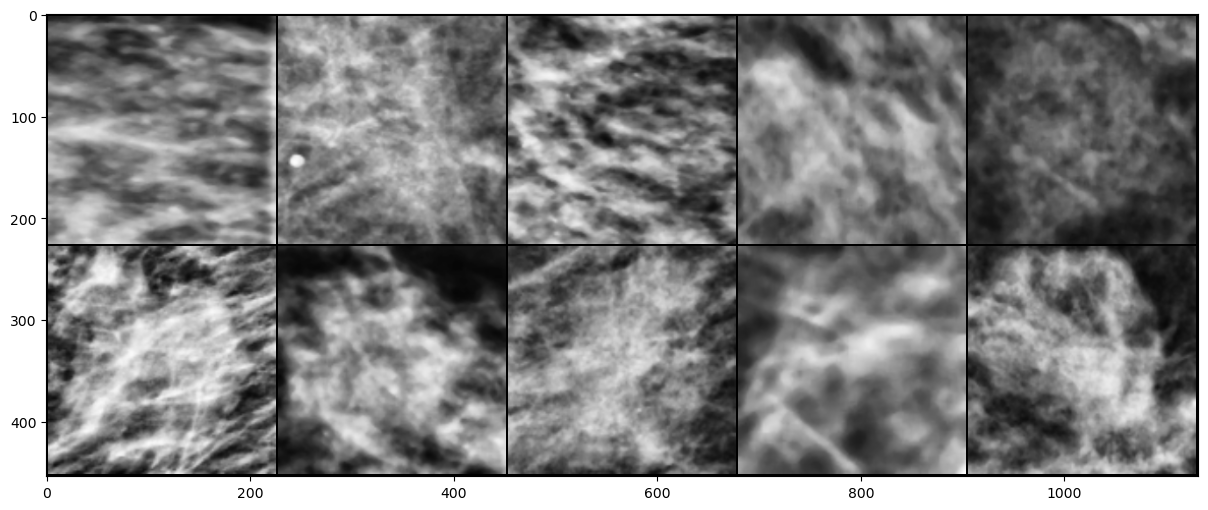

Target labels (Malignant/Benign):
['Malignant', 'Malignant', 'Malignant', 'Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant']

Classifier predictions (Malignant/Benign):
['Benign', 'Malignant', 'Benign', 'Benign', 'Benign', 'Malignant', 'Benign', 'Malignant', 'Benign', 'Benign']

-----Before Threshold Adjustment-----


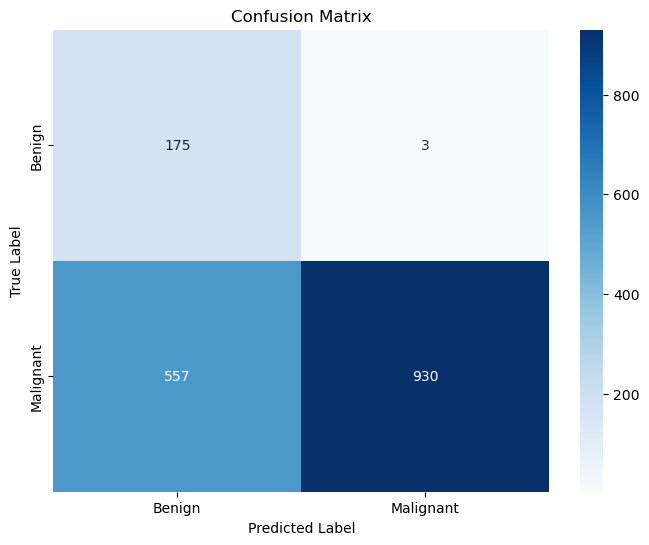

Overall Accuracy: 66.37%
Overall Recall (Sensitivity): 62.54%
Overall Precision: 99.68%
Overall F1 Score: 0.77

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.24      0.98      0.38       178
   Malignant       1.00      0.63      0.77      1487

    accuracy                           0.66      1665
   macro avg       0.62      0.80      0.58      1665
weighted avg       0.92      0.66      0.73      1665

True Positives (Malignant correctly classified): 930
True Negatives (Benign correctly classified): 175
False Positives (Benign incorrectly classified as Malignant): 3
False Negatives (Malignant incorrectly classified as Benign): 557


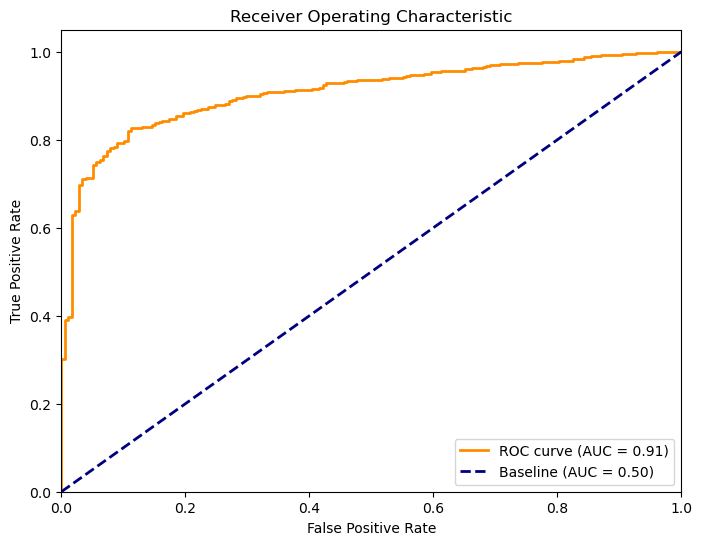

AUC Score: 0.91


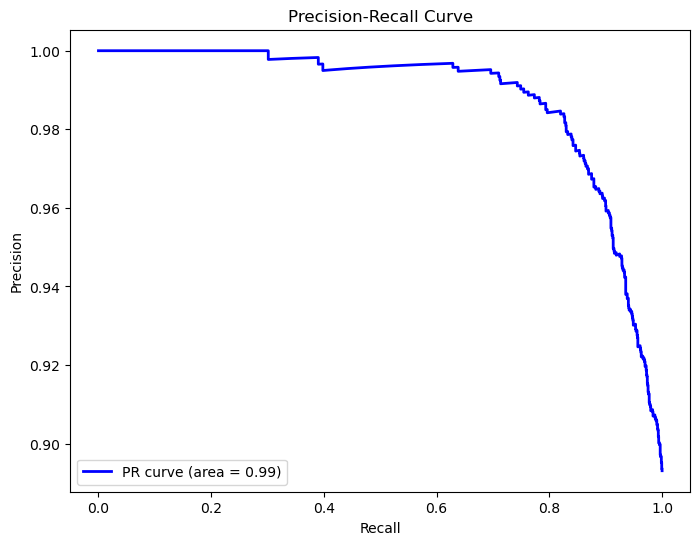

Precision-Recall AUC Score: 0.99


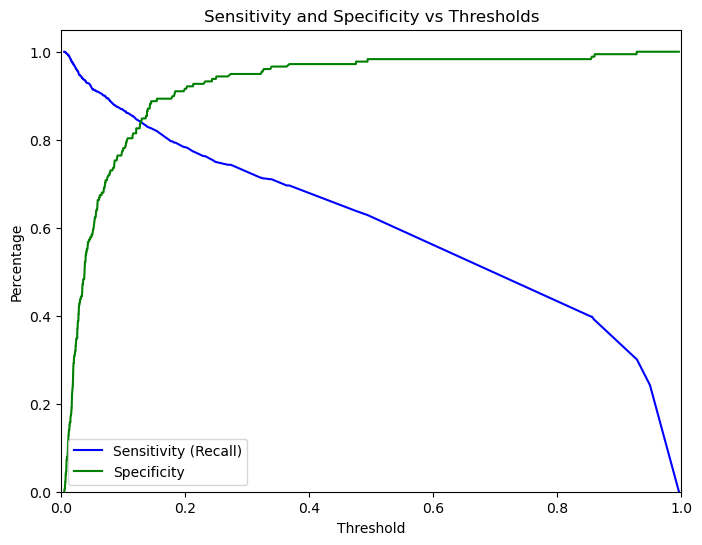

Best Threshold: 0.16161616161616163
Best Metric Value (Balanced Accuracy): 0.8541611569935696


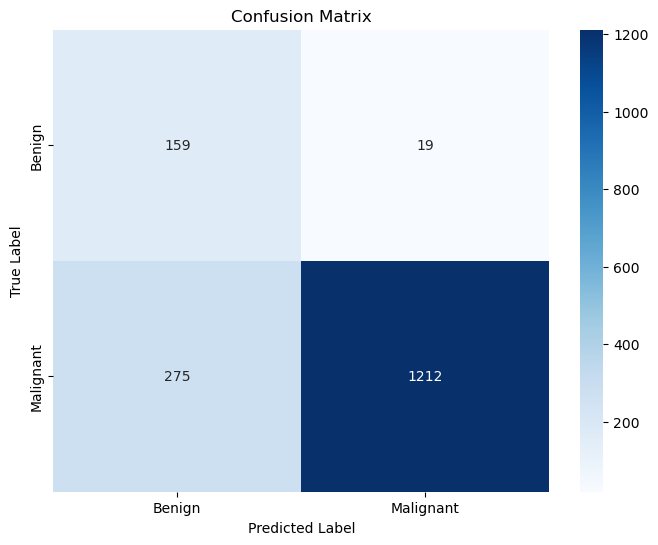

Detailed Classification Report:
-----After Threshold Adjustment-----
              precision    recall  f1-score   support

      Benign       0.37      0.89      0.52       178
   Malignant       0.98      0.82      0.89      1487

    accuracy                           0.82      1665
   macro avg       0.68      0.85      0.71      1665
weighted avg       0.92      0.82      0.85      1665

Overall Accuracy: 82.34%
Overall Recall (Sensitivity): 81.51%
Overall Precision: 98.46%
Overall F1 Score: 0.89
True Positives (Malignant correctly classified): 1212
True Negatives (Benign correctly classified): 159
False Positives (Benign incorrectly classified as Malignant): 19
False Negatives (Malignant incorrectly classified as Benign): 275


In [5]:
# Load a pre-trained Vision Transformer model for image classification
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',  # Pre-trained model name
    num_labels=2,                   # Number of output labels
    ignore_mismatched_sizes=True    # Ignore size mismatches during loading
)

# Load the state dictionary from our previously saved model
vit_model.load_state_dict(torch.load('vit_classifier.pth'))

vit_model = vit_model.to(device)

# Set the number of visualizations to generate
num_viz = 10

# Specify the model type for evaluation
model_type='vit'

# Evaluate the model using the test data loader
evaluation_results = evaluate_model(test_loader, vit_model, device, num_viz, eval_batchsize, model_type)

## Plot graph of the hyperparameters fine-tuning

In [ ]:
# Initialize a W&B run
run = wandb.init()

# Retrieve the W&B run object
run_id = 'breast-cancer-classification/t3okizap'
api = wandb.Api()
run = api.run(run_id)

# Get the lists from the run summary
train_accs_lr_000005_32_AdamW_StepLR = run.summary['train_accs']
train_losses_lr_000005_32_AdamW_StepLR = run.summary['train_losses']
val_accs_lr_000005_32_AdamW_StepLR = run.summary['val_accs']
val_losses_lr_000005_32_AdamW_StepLR = run.summary['val_losses']

wandb.finish()

In [ ]:
# Initialize a W&B run
run = wandb.init()

# Retrieve the W&B run object
run_id = 'breast-cancer-classification'
api = wandb.Api()
run = api.run(run_id)

# Get the lists from the run summary
train_accs_lr_000005_16_AdamW_StepLR = run.summary['train_accs']
train_losses_lr_000005_16_AdamW_StepLR = run.summary['train_losses']
val_accs_lr_000005_16_AdamW_StepLR = run.summary['val_accs']
val_losses_lr_000005_16_AdamW_StepLR = run.summary['val_losses']

wandb.finish()

In [ ]:
# Initialize a W&B run
run = wandb.init()

# Retrieve the W&B run object
run_id = 'breast-cancer-classification'
api = wandb.Api()
run = api.run(run_id)

# Get the lists from the run summary
train_accs_lr_00005_16_AdamW_ReduceLROnPlateau = run.summary['train_accs']
train_losses_lr_00005_16_AdamW_ReduceLROnPlateau = run.summary['train_losses']
val_accs_lr_00005_16_AdamW_ReduceLROnPlateau = run.summary['val_accs']
val_losses_lr_00005_16_AdamW_ReduceLROnPlateau = run.summary['val_losses']

wandb.finish()

In [ ]:
# Initialize a W&B run
run = wandb.init()

# Retrieve the W&B run object
run_id = 'breast-cancer-classification'
api = wandb.Api()
run = api.run(run_id)

# Get the lists from the run summary
train_accs_lr_00005_32_AdamW_ReduceLROnPlateau = run.summary['train_accs']
train_losses_lr_00005_32_AdamW_ReduceLROnPlateau = run.summary['train_losses']
val_accs_lr_00005_32_AdamW_ReduceLROnPlateau = run.summary['val_accs']
val_losses_lr_00005_32_AdamW_ReduceLROnPlateau = run.summary['val_losses']

wandb.finish()

In [ ]:
# Define a list of all accuracies and losses for easier iteration
data = [
    (train_accs_lr_000005_32_AdamW_StepLR, val_accs_lr_000005_32_AdamW_StepLR, train_losses_lr_000005_32_AdamW_StepLR, val_losses_lr_000005_32_AdamW_StepLR, 'lr=0.000005, bs=32, AdamW, StepLR'),
    (train_accs_lr_000005_16_AdamW_StepLR, val_accs_lr_000005_16_AdamW_StepLR, train_losses_lr_000005_16_AdamW_StepLR, val_losses_lr_000005_16_AdamW_StepLR, 'lr=0.000005, bs=16, AdamW, StepLR'),
    (train_accs_lr_00005_16_AdamW_ReduceLROnPlateau, val_accs_lr_00005_16_AdamW_ReduceLROnPlateau, train_losses_lr_00005_16_AdamW_ReduceLROnPlateau, val_losses_lr_00005_16_AdamW_ReduceLROnPlateau, 'lr=0.00005, bs=16, AdamW, ReduceLROnPlateau'),
    (train_accs_lr_00005_32_AdamW_ReduceLROnPlateau, val_accs_lr_00005_32_AdamW_ReduceLROnPlateau, train_losses_lr_00005_32_AdamW_ReduceLROnPlateau, val_losses_lr_00005_32_AdamW_ReduceLROnPlateau, 'lr=0.00005, bs=32, AdamW, ReduceLROnPlateau')
]

# Set the style
sns.set(style="whitegrid")

# Plotting accuracies
plt.figure(figsize=(12, 6))
for train_accs, val_accs, _, _, label in data:
    plt.plot(train_accs, linestyle='-', marker='o', label=f'Train {label}')
    plt.plot(val_accs, linestyle='--', marker='x', label=f'Val {label}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracies')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting losses
plt.figure(figsize=(12, 6))
for _, _, train_losses, val_losses, label in data:
    plt.plot(train_losses, linestyle='-', marker='o', label=f'Train {label}')
    plt.plot(val_losses, linestyle='--', marker='x', label=f'Val {label}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training and Validation Losses')
plt.grid(True)
plt.tight_layout()
plt.show()